# Bayesian Workflow in the 0-inflated model

##### Keywords: glm, regression, poisson regression, link-function, zero-inflated, mixture model, bayesian workflow

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

## Monks who drink: the Zero-Inflated Poisson Model

From McElreath:

>Now imagine that the monks take breaks on some days. On those days, no manuscripts are completed. Instead, the wine cellar is opened and more earthly delights are practiced. As the monastery owner, you'd like to know how often the monks drink. The obstacle for inference is that there will be zeros on honest non-drinking days, as well, just by chance. So how can you estimate the number of days spent drinking?

![](images/a-st-bernardus-prior-8.jpg)

The kind of model used to solve this problem is called a **Mixture Model**. We'll see these in more detail next week, but here is a simple version that arises in Poisson regression.

Let $p$ be the probability that the monks spend the day drinking, and $\lambda$ be the mean number of manuscripts completed, when they work.


### Likelihood

The likelihood of observing 0 manuscripts produced is is:

 $$\cal{L}(y=0) = p + (1-p) e^{-\lambda},$$

since the Poisson likelihood of $y$ is $ \lambda^y exp(–\lambda)/y!$

Likelihood of a non-zero $y$ is:

 $$\cal{L}(y \ne 0) = (1-p) \frac{\lambda^y e^{-\lambda}}{y!}$$

This model can be described by this diagram, taken from Mc-Elreath

![](images/zinfmonks.png)


### Generating the data

We're throwing bernoullis for whether a given day in the year is a drinking day or not...

In [2]:
from scipy.stats import binom
p_drink=0.2
rate_work=1
N=365
drink=binom.rvs(n=1, p=p_drink, size=N)
drink

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0,

On days we dont drink, we produce some work...though it might be 0 work...

In [3]:
from scipy.stats import poisson
y = ( 1 - drink)*poisson.rvs(mu=rate_work, size=N)
y

array([1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 3, 2, 3,
       2, 1, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 0, 4, 0, 1, 5, 2, 3, 0, 0, 1,
       2, 0, 0, 0, 1, 3, 0, 2, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0,
       2, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 3, 3, 0, 0, 0, 1, 1, 2, 0,
       0, 1, 1, 0, 0, 1, 2, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0,
       0, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 4, 2, 0, 1, 0, 1, 3, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 3, 1, 0, 0, 0, 2, 1, 0, 1, 2, 2, 0, 3, 0, 1, 2, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1,
       0, 2, 1, 0, 4, 2, 0, 0, 0, 0, 1, 2, 2, 2, 4, 0, 1, 3, 1, 0, 0, 3, 1,
       1, 1, 1, 0, 1, 1, 3, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 1, 0,
       0, 0,

Lets manufacture a histogram of manuscripts produced in a day.

In [4]:
zeros_drink=np.sum(drink)
a=drink==0
b=y==0
zeros_work=np.sum(a & b)
zeros_drink, zeros_work, np.sum(b)

(69, 103, 172)

(array([ 172.,  117.,   49.,   20.,    6.,    1.,    0.,    0.,    0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

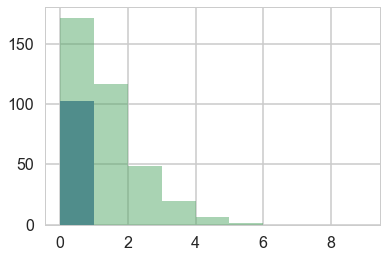

In [5]:
plt.hist(zeros_work*[0], bins=np.arange(10))
plt.hist(y, bins=np.arange(10), alpha=0.5)

### Lets throw in some domain expertise

*A survey of Abbey Heads has told us, that the most a monk could produce, ever, was 10 manuscripts in a day.*

## First model: just do a poisson

In [7]:
import theano.tensor as t

In [18]:
def model_poisson(data):
    with pm.Model() as model1:
        alpha=pm.Normal("alpha", 0,100)
        logmu = alpha
        like = pm.Poisson("obsv", mu=t.exp(logmu), observed=data)
        lambda0 = pm.Deterministic("lambda0", t.exp(alpha))
    return model1
model1 = model_poisson(y)

In [19]:
with model1:
    trace1=pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
100%|██████████| 4000/4000 [00:02<00:00, 1799.36it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115817588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114bf5eb8>]], dtype=object)

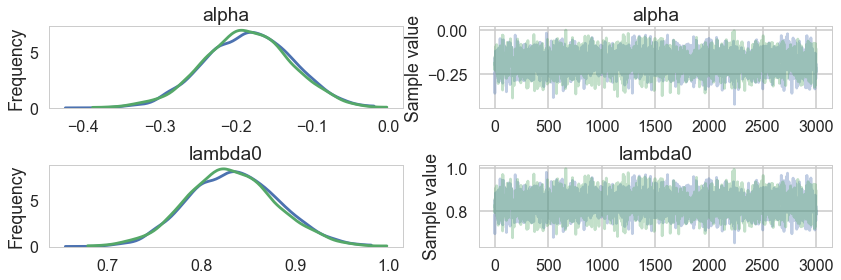

In [20]:
pm.traceplot(trace1)

In [21]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.184371,0.057111,0.001032,-0.297168,-0.075473,2562.0,1.000351
lambda0,0.832983,0.047501,0.000864,0.742139,0.926474,2554.0,1.000351


## Some proper workflow

Notice the prior specification though: at the 2$\sigma$ level, $\lambda$ could range from exp(-200) to exp(200), ie from 0 to an extremely large number to an extremely large "mean" of counts. Not possible. Indeed, the max count is around 10. For a poisson, since the variance is equal to the mean, this means that (at 3$\sigma):

$$max(\lambda + 3\sqrt{\lambda}) < 10$$

Any prior should only take us marginally outside this range:

In [25]:
5+3*np.sqrt(5)

11.708203932499369

### Limiting the prior

Thus a prior should mainly limit $\lambda$ to values upto 5. To so this consider:

In [213]:
from scipy.stats import halfnorm
halfnorm.ppf(0.99, loc=0,scale=4)

10.303317214195602

### Simulating the Bayesian Joint distribution

This should be way enough!, So lets go again:

First we create a decorator using code from https://github.com/ColCarroll/sampled

In [86]:
class ObserverModel(pm.Model):
    """Stores observed variables until the model is created."""
    def __init__(self, observed):
        self.observed = observed
        super(ObserverModel, self).__init__()

    def Var(self, name, dist, data=None, total_size=None):
        return super(ObserverModel, self).Var(name, dist,
                                              data=self.observed.get(name, data),
                                              total_size=total_size)


def sampled(f):
    """Decorator to delay initializing pymc3 model until data is passed in."""
    def wrapped_f(**observed):
        try:
            with ObserverModel(observed) as model:
                f(**observed)
        except TypeError:
            with ObserverModel(observed) as model:
                f()
        return model
    return wrapped_f

In [161]:
@sampled
def model_poisson1(verbose=0):
    mu = pm.HalfNormal("mu", 3)
    like = pm.Poisson("obsv", mu=mu)

In [162]:
with model_poisson1():
    t_nodata = pm.sample(1000, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [mu_log__]
>Metropolis: [obsv]
 93%|█████████▎| 1395/1500 [00:01<00:00, 1255.15it/s]//anaconda/envs/py3l/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 1500/1500 [00:01<00:00, 1251.33it/s]
Tuning was enabled throughout the whole trace.
Only one chain was sampled, this makes it impossible to run some convergence checks


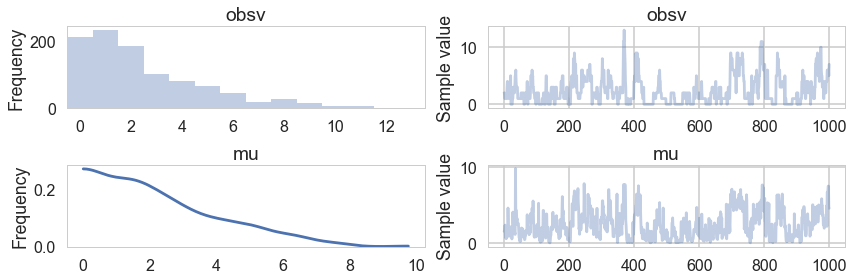

In [163]:
pm.traceplot(t_nodata);

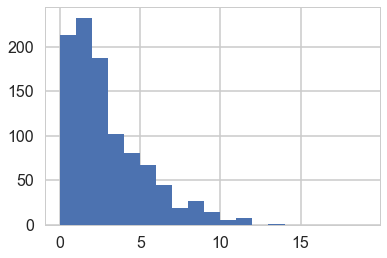

In [164]:
plt.hist(t_nodata['obsv'], bins=np.arange(0,20,1));

In [ ]:
mus = t_nodata.get_values('mu')
mus.shape

### Simulating replicate prior predictives

In [100]:
replicate_pp = np.empty((200,200))

In [101]:
for i,mu in enumerate(mus):
    if i%10==0:
        print("iter", i)
    with model_poisson1(mu=mu):
        temp_nodata = pm.sample(200, progressbar=False, chains=1)
    replicate_pp[i,:] = temp_nodata.get_values('obsv')

iter 0


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 10


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 20


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 30


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 40


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 50


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 60


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 70


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 80


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 90


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 100


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 110


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 120


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 130


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 140


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 150


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 160


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 170


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 180


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

iter 190


Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
Metropolis: [obsv]
Only one chain was sampled, this makes it impossible to run some convergence checks

In [139]:
with model_poisson1(obsv=replicate_pp[0,:]):
    tpost = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
100%|██████████| 1500/1500 [00:00<00:00, 1585.16it/s]
The acceptance probability does not match the target. It is 0.884204635079, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120cf1be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12274be48>]], dtype=object)

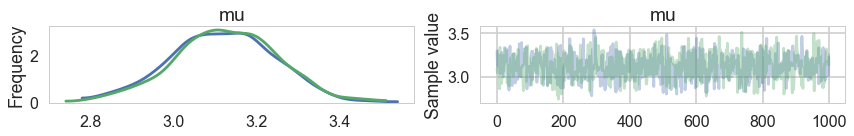

In [140]:
pm.traceplot(tpost)

In [141]:
mus[0]

2.807525696673618

In [142]:
np.std(tpost['mu'])

0.12507126731431462

In [143]:
pm.summary(tpost)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,3.12099,0.125071,0.003999,2.864898,3.354582,758.0,1.000367


In [110]:
replicate_post=np.empty((200, 200))
for i,mu in enumerate(mus):
    if i%10==0:
        print("iter", i)
    with model_poisson1(obsv=replicate_pp[i,:]):
        temp_simdata = pm.sample(200, progressbar=False, chains=1)
    replicate_post[i,:] = temp_simdata.get_values('mu')

iter 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.87983360042, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.8798054762, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run

iter 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.886364831976, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS

iter 50


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.883216060125, but should be close to 0.8. Try 

iter 60


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 70


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.89484935899, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.880906634377, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to r

iter 80


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.88641777936, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS:

iter 90


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.881200503138, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS

iter 100


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 110


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.903203993268, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.882559193625, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to 

iter 120


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.891550853837, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS

iter 130


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 140


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.89354336552, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS:

iter 150


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.903762471064, but should be close to 0.8. Try 

iter 160


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 170


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 180


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS samp

iter 190


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.883053604825, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log__]
Only 200 samples in chain.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS

In [111]:
replicate_post.shape

(200, 200)

I found this to be painfully slow in pymc3, so just simulated replicates from `scipy.stats`. The reason for this in pymc3 is that it will want to use NUTS for this.

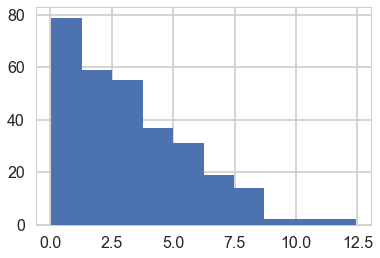

In [184]:
mus = halfnorm(scale=4).rvs(300)
plt.hist(mus);

### Simulate replicate predictives directly

In [169]:
from scipy.stats import poisson

In [172]:
y.shape

(365,)

In [185]:
replicate_pp = np.zeros((300,365))
for i,mu in enumerate(mus):
    if i%100==0:
        print("iter", i)
    replicate_pp[i,:] = poisson(mu).rvs(365)

iter 0
iter 100
iter 200


In [186]:
replicate_pp[3,:]

array([ 0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0

### Simulating replicate posteriors

In [188]:
replicate_post=np.empty((300, 2000))
for i,mu in enumerate(mus):
    if i%30==0:
        print("iter", i)
    with model_poisson1(obsv=replicate_pp[i,:]):
        temp_simdata = pm.sample(1000, tune=1000, progressbar=False)
    replicate_post[i,:] = temp_simdata.get_values('mu')

iter 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS

iter 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
The acceptance probability does not match the target. It is 0.886002157963, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
The number of effective samples is s

iter 60


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
INFO (theano.gof.compilelock): Refreshing lock /Users/rahul/.theano/compiledir_Darwin-16.1.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing N

iter 90


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
The acceptance probability does not match the target. It is 0.712667601545, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initi

iter 120


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 

iter 150


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
INFO (theano.gof.compilelock): Refreshing lock /Users/rahul/.theano/compiledir_Darwin-16.1.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing N

iter 180


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
The acceptance probability does not match the target. It is 0.881796219178, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initi

iter 210


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
INFO (theano.gof.compilelock): Refreshing lock /Users/rahul/.theano/compiledir_Darwin-16.1.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing N

iter 240


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS

iter 270


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
INFO (theano.gof.compilelock): Refreshing lock /Users/rahul/.theano/compiledir_Darwin-16.1.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
Auto-assigning NUTS sampler...
Initializing N

### Calculating simulated posterior statistics

In [189]:
def sbc_rank(source_param, param_post):
    return np.sum(source_param < param_post)
def z_scores(source_param, param_post):
    mean_param = np.mean(param_post)
    std_param = np.std(param_post)
    zs = np.abs(mean_param - source_param)/std_param
    return zs
def shrinkages(std_source, source_param, param_post):
    std_param = np.std(param_post)
    zs = 1. - (std_param*std_param)/(std_source*std_source)
    return zs    

In [191]:
ranks=np.empty(300, dtype='int')
for i, mu in enumerate(mus):
    ranks[i] = sbc_rank(mus[i], replicate_post[i,:])
ranks

array([1149,  563,  203,  424, 1904,    7,   50,  946, 1637,  286,  222,
        237,  336,  433, 1659, 1913,  887, 1732,  947,  972,  163,  435,
        447, 1876,  191, 1656, 1303, 1373,  262,  318,  558,  878,  690,
        545, 1380, 1062, 1291, 1095,  911, 1251,  502, 1827, 1864, 1552,
       1263, 1663, 1783,  479,  465,  891,  210,   20, 1159, 1661, 1685,
        107,  600, 1958, 1982, 1129, 1412,  602, 1752,  913,   64,   84,
        278,  329,  985, 1144,  344,  345, 1996,  655,  984,  749,  247,
        985,  921, 1091, 1589,  691,  831,  199, 1015, 1055, 1038,  487,
       1631,  680, 1757,  658, 1957,  809, 1689, 1135, 1143, 1118, 1137,
       1695, 1500,  851,  560,  174, 1723,  941, 1577,  536,  278,  148,
        842,  853,  949,  739,  695, 1489, 1387,  575,   62, 1608,  631,
       1105,  677,  503, 1164,  112, 1413, 1638, 1017, 1376,  409, 1181,
       1167, 1618,  710, 1087, 1397,  238, 1028, 1011,  372,  849, 1091,
        389, 1341, 1354, 1930,  644,  241,   48,  8

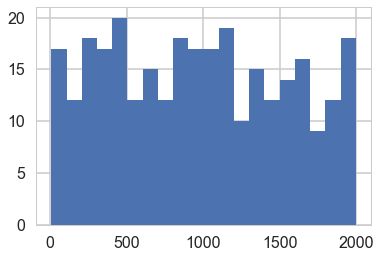

In [199]:
plt.hist(ranks, bins=20);

In [200]:
zs=np.empty(300)
for i, mu in enumerate(mus):
    zs[i] = z_scores(mus[i], replicate_post[i,:])
zs

array([ 0.20875485,  0.6016904 ,  1.30960137,  0.78702808,  1.61928975,
        2.72716747,  1.92635271,  0.06241117,  0.93301711,  1.07425741,
        1.2487615 ,  1.16310945,  0.95943601,  0.80353487,  0.93391784,
        1.70004167,  0.09650991,  1.12731801,  0.01417322,  0.02712168,
        1.39434016,  0.77834144,  0.73487566,  1.46121666,  1.3120801 ,
        0.93363934,  0.41220237,  0.46541861,  1.09927987,  1.01407185,
        0.5912949 ,  0.14615846,  0.43049123,  0.60427031,  0.51333796,
        0.06269162,  0.35575461,  0.13648075,  0.07075337,  0.31533356,
        0.62646438,  1.36797655,  1.51295293,  0.75373567,  0.3587438 ,
        0.97089641,  1.24595026,  0.705806  ,  0.73371445,  0.10486241,
        1.29165145,  2.24159285,  0.22603826,  0.98767204,  1.00203528,
        1.62795917,  0.51463461,  1.92874092,  2.33878002,  0.20150074,
        0.54585983,  0.49362192,  1.1776072 ,  0.0998092 ,  1.85516996,
        1.73873001,  1.10442061,  0.94528093,  0.00685128,  0.16

In [201]:
shrinks=np.empty(300)
for i, mu in enumerate(mus):
    shrinks[i] = shrinkages(3, mus[i], replicate_post[i,:])
shrinks

array([ 0.99977506,  0.99896202,  0.99900691,  0.99990726,  0.99797211,
        0.99813254,  0.99961598,  0.9991045 ,  0.99871173,  0.99895253,
        0.9984847 ,  0.99985669,  0.99952059,  0.99988587,  0.99899191,
        0.99941079,  0.99768422,  0.99902108,  0.99925125,  0.99893121,
        0.99973892,  0.99839893,  0.99867078,  0.99989354,  0.99947806,
        0.99866525,  0.99940548,  0.999391  ,  0.99922751,  0.99795002,
        0.99943871,  0.99817535,  0.99834013,  0.99937265,  0.99899361,
        0.99833735,  0.99897109,  0.99816391,  0.99991506,  0.998935  ,
        0.99994518,  0.99923426,  0.99970918,  0.99933279,  0.99976849,
        0.99810943,  0.99742328,  0.99996801,  0.99782177,  0.99866496,
        0.99962818,  0.99799427,  0.99976425,  0.99746803,  0.99951758,
        0.99957197,  0.99740765,  0.99993072,  0.99920324,  0.9982549 ,
        0.99917911,  0.99978575,  0.99804508,  0.99943873,  0.99944222,
        0.99957388,  0.99957655,  0.99975464,  0.99995165,  0.99

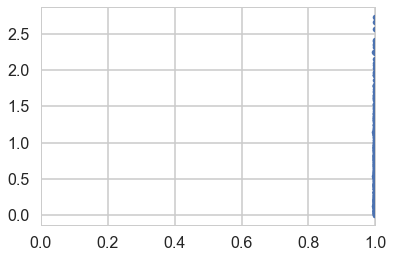

In [202]:
plt.plot(shrinks, zs, '.');
plt.xlim([0,1]);

In [204]:
mpo = model_poisson1(obsv=y)
with mpo:
    samples = pm.sample(2000, tune=1000)
posterior = samples.get_values('mu')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__]
100%|██████████| 3000/3000 [00:01<00:00, 1696.50it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127a5fe48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x129060dd8>]], dtype=object)

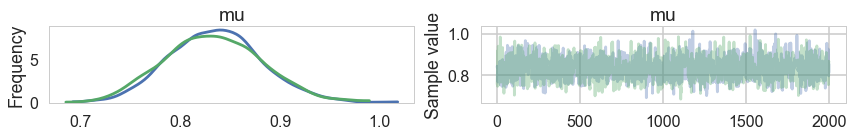

In [205]:
pm.traceplot(samples)

In [206]:
with mpo:
    samples_ppc = pm.sample_ppc(samples)

100%|██████████| 2000/2000 [00:00<00:00, 5438.02it/s]


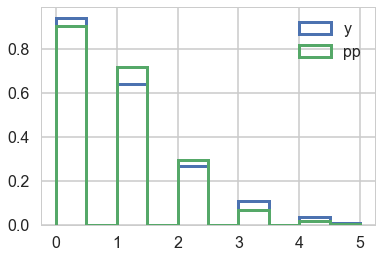

In [207]:
plt.hist(y,  normed=True, histtype='step', lw=3, label="y");
plt.hist(samples_ppc['obsv'],  normed=True, histtype='step', lw=3, label="pp")
plt.legend();

## A second model: 0 inflated poisson

The likelihood that combines the two cases considered above is called the **Zero Inflated poisson**. It has two arguments, the Poisson rate parameter, and the proportion of poisson variates (theta and psi in pymc).

In [208]:
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

In [209]:
with pm.Model() as model2:
    alphalam=pm.Normal("alphalam", 0,10)
    alphap=pm.Normal("alphap", 0,1)
    #regression models with intercept only
    logmu = alphalam
    logitp = alphap
    like = pm.ZeroInflatedPoisson("obsv", theta=t.exp(logmu), psi=tinvlogit(logitp), observed=y)
    lam = pm.Deterministic("lam", t.exp(logmu))
    p = pm.Deterministic("p", tinvlogit(logitp))

In [210]:
with model2:
    trace2=pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alphap, alphalam]
100%|██████████| 4000/4000 [00:04<00:00, 814.49it/s]


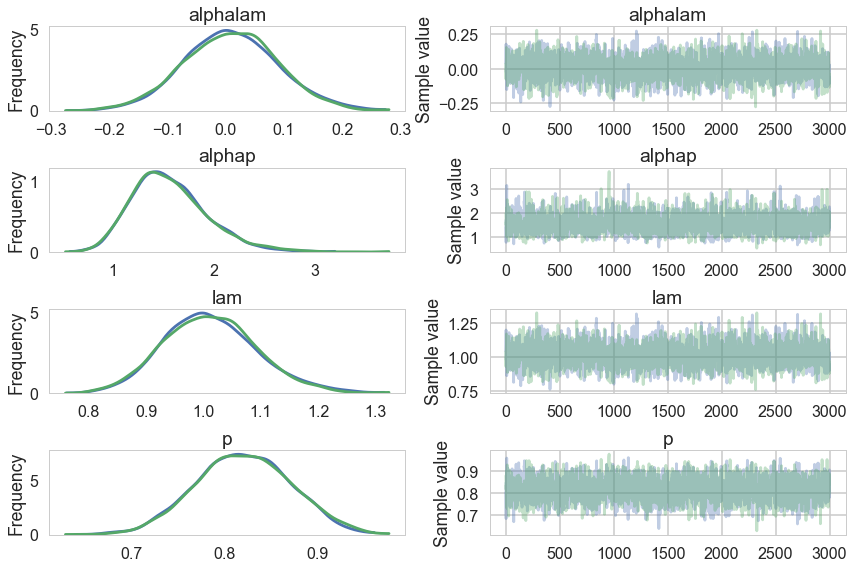

In [211]:
pm.traceplot(trace2);

In [212]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alphalam,0.008825,0.080045,0.001699,-0.149465,0.168037,2226.0,1.000092
alphap,1.560670,0.371543,0.008146,0.911753,2.296434,2046.0,1.000071
lam,1.012106,0.081300,0.001713,0.845978,1.166795,2234.0,1.000102
p,0.820273,0.050259,0.001066,0.723801,0.917328,2257.0,0.999963
